In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
import sys
import pdb
from copy import deepcopy
from tqdm import tqdm
import astropy.units as u
import mpl_scatter_density
from pylab import *
from scipy.optimize import curve_fit

from numpy import exp, linspace, random
import lmfit
from lmfit import Model
from lmfit.models import LorentzianModel, VoigtModel, GaussianModel

import seaborn as sns
plt.style.use('seaborn')

/var/folders/d7/mj7t5gvn7kxcpnv91gn5rxs5myk4z8/T/ipykernel_87762/2486843552.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
sys.path.append('/Users/anh5866/Desktop/Coding')
import PyXFocus.sources as sources
import PyXFocus.transformations as trans
import PyXFocus.surfaces as surfaces
import PyXFocus.analyses as analyses
import PyXFocus.conicsolve as conic

import OGRE.ogre_routines_alexplay as ogre

soxs : [WARNING  ] 2025-03-27 13:43:09,335 Setting 'soxs_data_dir' to /Users/anh5866/Library/Caches/soxs for this session. Please update your configuration if you want it somewhere else.


In [3]:
#control center 

num_rays = 1000000

pin_rad = 0.01 #mm 
#pin_rad = 0.03 #mm 

#both in arcseconds
pitch_val = 300
yaw_val = 0

#how far you let collimated beam travel
length = 1800 * u.mm 

In [4]:
z0_first = 1860 * u.mm  # Focal length for reverse (f/4.0)
far_away = 1e5 * u.mm

#z0_first = (1860 - 465) * u.mm 


r_prim = 457.2/2 * u.mm  #18 inch diameter
#r_prim_rad = 1861.82 * u.mm #radius of curvature is 73.3 inches
r_prim_rad = 3720 * u.mm #radius of curvature is 73.3 inches

## maybe radius of curvature is wrong, understand 


wave = 505 * u.nm # wavelength of the LED

In [5]:
LED_to_pin = 8 #mm changing it to illuminate JET-X
#LED_to_pin = 9.535 #mm what it actually is
diag_LED = 1.4 #mm 

i_0 = LED_to_pin/ (1+(pin_rad/diag_LED))
div_rad = np.arctan(diag_LED/(2*i_0))
div_deg = degrees(div_rad)


#div = (np.tan(pin_rad/LED_to_pin)) #radians 
#divergence radius 

print(div_deg)
print(div_rad)


5.036180440498532
0.08789793041123775


In [6]:
#rays = sources.pointsource(0.05, num_rays)

rays = sources.circularbeam(pin_rad,num_rays) #size of fiber optic 

#rays = sources.pointsource(0.01, num_rays)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.00344206, -0.00583152,  0.00842624, ...,  0.00581902,
        -0.00649678,  0.00703146]),
 array([-0.00447633,  0.00293203, -0.00180684, ..., -0.00761706,
        -0.00491377, -0.00103473]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

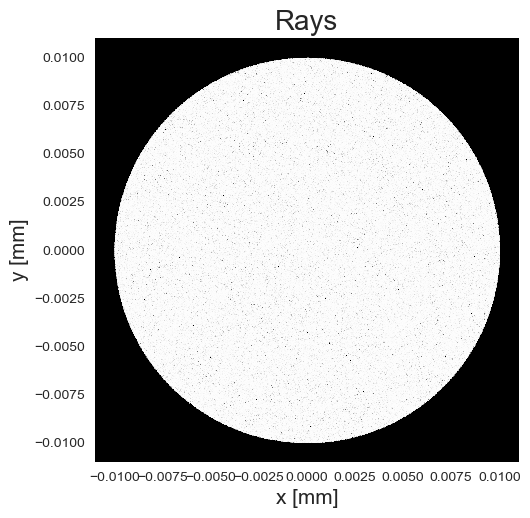

In [7]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    #fig1,ax1 = plt.subplots(figsize=(8,8))
    fig1,ax1 = plt.subplots()
    
    ax1.set_aspect('equal', adjustable='box')
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

In [8]:
# Radial direction cosine magnitude
rho = np.sqrt(np.random.rand(num_rays))*np.sin(div_rad) #divergence of, half angle 
#rho = np.sqrt(np.random.rand(100000))*np.sin(1.5708) #90 degrees, max half angle div 
theta = np.random.rand(num_rays)*2*np.pi
l = rho*np.cos(theta)
m = rho*np.sin(theta)
n = np.sqrt(1.-l**2-m**2)

rays = [rays[0], rays[1], rays[2], rays[3],
        l, m, n, rays[7], rays[8], rays[9]]

rays


[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.00344206, -0.00583152,  0.00842624, ...,  0.00581902,
        -0.00649678,  0.00703146]),
 array([-0.00447633,  0.00293203, -0.00180684, ..., -0.00761706,
        -0.00491377, -0.00103473]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.06786992,  0.00861787, -0.04972681, ..., -0.03883859,
        -0.02896169,  0.03416614]),
 array([-0.01952418, -0.07476656,  0.047582  , ..., -0.0091928 ,
        -0.04697595,  0.02336328]),
 array([0.99750312, 0.99716383, 0.99762879, ..., 0.99920321, 0.99847608,
        0.99914305]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [9]:
trans.transform(rays, 0, 0, -z0_first.to('mm').value, 0, 0, 0)
#surfaces.flat(rays) #uncomment if you want to see divergence 

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.00344206, -0.00583152,  0.00842624, ...,  0.00581902,
        -0.00649678,  0.00703146]),
 array([-0.00447633,  0.00293203, -0.00180684, ..., -0.00761706,
        -0.00491377, -0.00103473]),
 array([1860., 1860., 1860., ..., 1860., 1860., 1860.]),
 array([-0.06786992,  0.00861787, -0.04972681, ..., -0.03883859,
        -0.02896169,  0.03416614]),
 array([-0.01952418, -0.07476656,  0.047582  , ..., -0.0091928 ,
        -0.04697595,  0.02336328]),
 array([0.99750312, 0.99716383, 0.99762879, ..., 0.99920321, 0.99847608,
        0.99914305]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

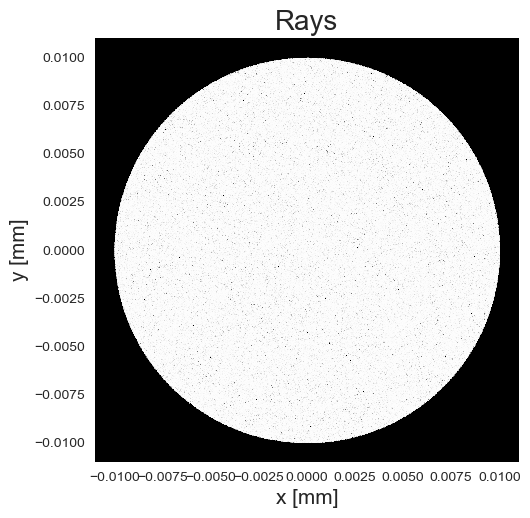

In [10]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    #fig1,ax1 = plt.subplots(figsize=(8,8))
    fig1,ax1 = plt.subplots()
    ax1.set_aspect('equal', adjustable='box')
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')
    
    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

/Users/anh5866/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/anh5866/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


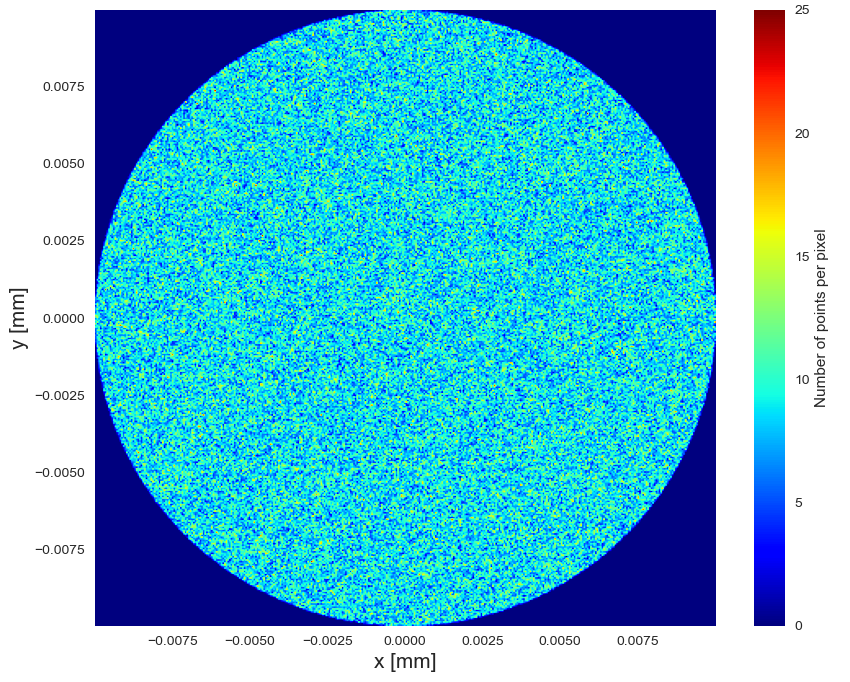

In [11]:
sns.set_style("ticks")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1, 1, 1, projection='scatter_density')

#color_map = plt.get_cmap('plasma')
color_map = plt.get_cmap('jet')

density = ax1.scatter_density(rays[1], rays[2], cmap = color_map)
#ax1.set_ylim(-180,180)
#ax1.set_xlim(-180,180)

ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)

#ax1.set_title("Rays", fontsize=20)

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)

fig.colorbar(density, label='Number of points per pixel')

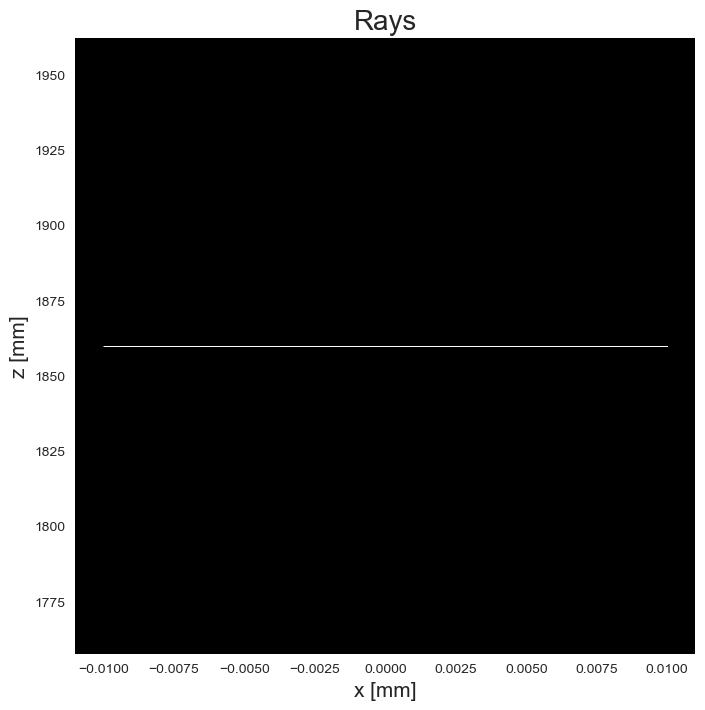

In [12]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('z [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')
    
    ax1.scatter(rays[1], rays[3], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

In [13]:
# add vignette here

In [14]:
surfaces.conic(rays, r_prim_rad.to('mm').value, -1)
trans.reflect(rays)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([126.39928063, -16.05782756,  92.61007741, ...,  72.274387  ,
         53.90332538, -63.56923825]),
 array([ 36.35588275, 139.26621047, -88.60937664, ...,  17.09781016,
         87.43698818, -43.4753652 ]),
 array([2.32507102, 2.64152301, 2.20809786, ..., 0.74138738, 1.41811766,
        0.79719831]),
 array([ 1.84559206e-06, -3.13015397e-06,  4.51811201e-06, ...,
         3.12563258e-06, -3.48696987e-06,  3.77675077e-06]),
 array([-2.40439242e-06,  1.56870960e-06, -9.63808660e-07, ...,
        -4.09394839e-06, -2.63450587e-06, -5.57425009e-07]),
 array([-1., -1., -1., ..., -1., -1., -1.]),
 array([-0.03395708,  0.00431356, -0.02488042, ..., -0.01942473,
        -0.01448462,  0.01708484]),
 array([-0.00976698, -0.0374106 ,  0.0238056 , ..., -0.00459527,
        -0.02349561,  0.01168442]),
 array([0.99937557, 0.99929067, 0.99940695, ..., 0.99980076, 0.999619  ,
        0.99978577])]

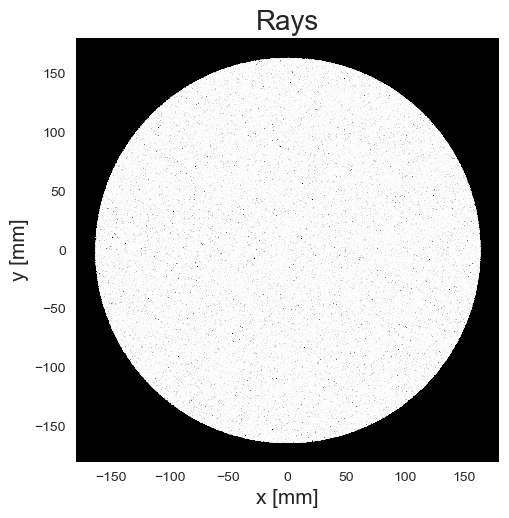

In [15]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    #fig1,ax1 = plt.subplots(figsize=(8,8))
    fig1,ax1 = plt.subplots()
    
    ax1.set_aspect('equal', adjustable='box')
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

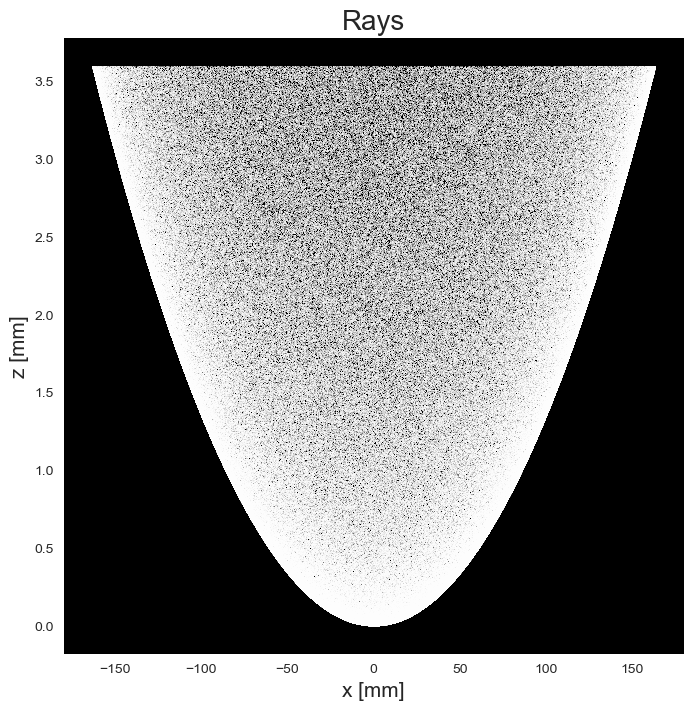

In [16]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    #fig1,ax1 = plt.subplots()
    
    #ax1.set_aspect('equal', adjustable='box')
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('z [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[3], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

In [17]:
print((np.max(rays[1]))*2) #how much of mirror is illuminated 

327.1731957768515


In [18]:
#f0 = surfaces.focusX(rays) #put z to focus 
#print(f0)
#trans.transform(rays, 0, 0, f0, 0, 0, 0)


trans.transform(rays, 0, 0, length.to('mm').value, 0, 0, 0)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([126.39928063, -16.05782756,  92.61007741, ...,  72.274387  ,
         53.90332538, -63.56923825]),
 array([ 36.35588275, 139.26621047, -88.60937664, ...,  17.09781016,
         87.43698818, -43.4753652 ]),
 array([-1797.67492898, -1797.35847699, -1797.79190214, ...,
        -1799.25861262, -1798.58188234, -1799.20280169]),
 array([ 1.84559206e-06, -3.13015397e-06,  4.51811201e-06, ...,
         3.12563258e-06, -3.48696987e-06,  3.77675077e-06]),
 array([-2.40439242e-06,  1.56870960e-06, -9.63808660e-07, ...,
        -4.09394839e-06, -2.63450587e-06, -5.57425009e-07]),
 array([-1., -1., -1., ..., -1., -1., -1.]),
 array([-0.03395708,  0.00431356, -0.02488042, ..., -0.01942473,
        -0.01448462,  0.01708484]),
 array([-0.00976698, -0.0374106 ,  0.0238056 , ..., -0.00459527,
        -0.02349561,  0.01168442]),
 array([0.99937557, 0.99929067, 0.99940695, ..., 0.99980076, 0.999619  ,
        0.99978577])]

In [19]:
surfaces.flat(rays)

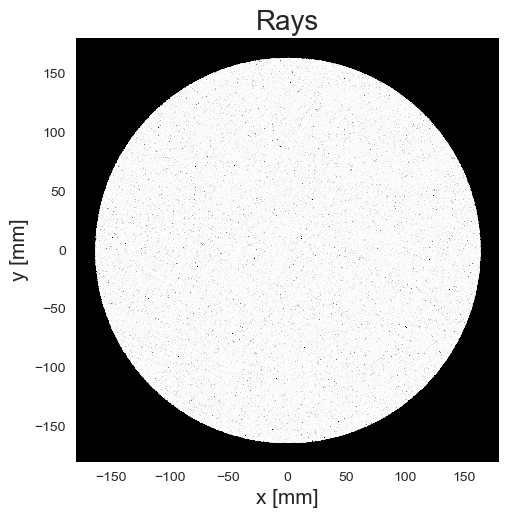

In [20]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    #fig1,ax1 = plt.subplots(figsize=(8,8))
    fig1,ax1 = plt.subplots()
    ax1.set_aspect('equal', adjustable='box')
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

In [21]:
print((np.max(rays[1]))*2)

327.1833722114733


In [22]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([126.39596286, -16.05220155,  92.60195478, ...,  72.26876318,
         53.90959698, -63.57603339]),
 array([ 36.36020506, 139.26339094, -88.60764391, ...,  17.10517623,
         87.44172656, -43.47436228]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 1.84559206e-06, -3.13015397e-06,  4.51811201e-06, ...,
         3.12563258e-06, -3.48696987e-06,  3.77675077e-06]),
 array([-2.40439242e-06,  1.56870960e-06, -9.63808660e-07, ...,
        -4.09394839e-06, -2.63450587e-06, -5.57425009e-07]),
 array([-1., -1., -1., ..., -1., -1., -1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

## Jet-X

In [23]:
# Define JET-X optic parameters.
z0 = 3500. * u.mm  # Focal length.

d_int = np.array([187.181697, 195.044289, 203.186973, 211.689775, 220.552696, 229.775737, 239.398908, 249.422212, 
                  259.865654, 270.729235, 282.052968, 293.856858]) * u.mm  # Diameter at intersection node.

r_int = d_int/2 #Radius at intersection node


mirror_length = 300 * u.mm  # Axial length of primary / secondary mirror.
mirror_sep = 0 * u.mm  # Separation between primary and secondary mirrors.

In [24]:
# Define inner and outer subannulus radii.
z_in = z0 + mirror_sep/2
z_out = z_in + mirror_length

print(z_in)
print(z_out)

r_in = conic.primrad(z_in, r_int[0], z0)
r_out = conic.primrad(z_out, r_int[-1], z0) #-1 is the last value in array 

print(r_in)
print(r_out)

3500.0 mm
3800.0 mm
93.5908484999825 mm
150.04216963869828 mm


In [25]:
# Define blank PyXFocus ray object.
new_rays = sources.annulus(0,0,0) 

# Define mirror parameters.
zp_back = z0 + mirror_sep/2  # Axial position of parabola front.
zp_front = zp_back + mirror_length  # axial position of parabola back.

rp_front = [conic.primrad(zp_front, r, z0) for r in r_int]
rp_back = [conic.primrad(zp_back, r, z0) for r in r_int]

#applies conic.primrad to 

print(rp_front)
print(rp_back)

print(r_in)
print(r_out)

print(r_int)

[<Quantity 95.57488881 mm>, <Quantity 99.5894855 mm>, <Quantity 103.74709054 mm>, <Quantity 108.08856388 mm>, <Quantity 112.61390502 mm>, <Quantity 117.32311337 mm>, <Quantity 122.23661642 mm>, <Quantity 127.35441427 mm>, <Quantity 132.68671967 mm>, <Quantity 138.23353132 mm>, <Quantity 144.01527733 mm>, <Quantity 150.04216964 mm>]
[<Quantity 93.5908485 mm>, <Quantity 97.5221445 mm>, <Quantity 101.5934865 mm>, <Quantity 105.8448875 mm>, <Quantity 110.276348 mm>, <Quantity 114.8878685 mm>, <Quantity 119.699454 mm>, <Quantity 124.711106 mm>, <Quantity 129.932827 mm>, <Quantity 135.3646175 mm>, <Quantity 141.026484 mm>, <Quantity 146.928429 mm>]
93.5908484999825 mm
150.04216963869828 mm
[ 93.5908485  97.5221445 101.5934865 105.8448875 110.276348  114.8878685
 119.699454  124.711106  129.932827  135.3646175 141.026484  146.928429 ] mm


In [26]:
# move global orgin to JET-X focus
trans.transform(rays, 0, 0, -z0.to('mm').value, 0, 0, 0)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([126.39596286, -16.05220155,  92.60195478, ...,  72.26876318,
         53.90959698, -63.57603339]),
 array([ 36.36020506, 139.26339094, -88.60764391, ...,  17.10517623,
         87.44172656, -43.47436228]),
 array([3500., 3500., 3500., ..., 3500., 3500., 3500.]),
 array([ 1.84559206e-06, -3.13015397e-06,  4.51811201e-06, ...,
         3.12563258e-06, -3.48696987e-06,  3.77675077e-06]),
 array([-2.40439242e-06,  1.56870960e-06, -9.63808660e-07, ...,
        -4.09394839e-06, -2.63450587e-06, -5.57425009e-07]),
 array([-1., -1., -1., ..., -1., -1., -1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [27]:
def arcsec_to_rad(arcsec):
    return arcsec / 3600 * math.pi / 180

arcsec_to_rad(pitch_val)

0.0014544410433286077

In [28]:
'''
rays[5] = np.full(len(rays[5]), arcsec_to_rad(pitch_val))
#rays[5] = rays[5] + arcsec_to_rad(pitch_val)
rays[6] = (np.sqrt(1 - rays[5]**2))*-1 #renormalization
#rays[6] = np.sqrt(1 - (rays[5]**2 + rays[4]**2)) 
#3d sphere have to subtract the x compontent and y component addativley for z to be one 

#rays[5] = np.ones(len(rays[5])) * pitch_val
#rays[6] = np.sqrt(1 - rays[5]**2)4
'''

'\nrays[5] = np.full(len(rays[5]), arcsec_to_rad(pitch_val))\n#rays[5] = rays[5] + arcsec_to_rad(pitch_val)\nrays[6] = (np.sqrt(1 - rays[5]**2))*-1 #renormalization\n#rays[6] = np.sqrt(1 - (rays[5]**2 + rays[4]**2)) \n#3d sphere have to subtract the x compontent and y component addativley for z to be one \n\n#rays[5] = np.ones(len(rays[5])) * pitch_val\n#rays[6] = np.sqrt(1 - rays[5]**2)4\n'

In [29]:
if pitch_val != 0:
    rays[5] = np.full(len(rays[5]), arcsec_to_rad(pitch_val))
    rays[6] = np.sqrt(1 - rays[5]**2)*-1  # Renormalization

In [30]:
if yaw_val != 0:
    rays[4] = np.full(len(rays[4]), arcsec_to_rad(yaw_val))
    rays[6] = np.sqrt(1 - rays[4]**2)*-1  # Renormalization

In [31]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([126.39596286, -16.05220155,  92.60195478, ...,  72.26876318,
         53.90959698, -63.57603339]),
 array([ 36.36020506, 139.26339094, -88.60764391, ...,  17.10517623,
         87.44172656, -43.47436228]),
 array([3500., 3500., 3500., ..., 3500., 3500., 3500.]),
 array([ 1.84559206e-06, -3.13015397e-06,  4.51811201e-06, ...,
         3.12563258e-06, -3.48696987e-06,  3.77675077e-06]),
 array([0.00145444, 0.00145444, 0.00145444, ..., 0.00145444, 0.00145444,
        0.00145444]),
 array([-0.99999894, -0.99999894, -0.99999894, ..., -0.99999894,
        -0.99999894, -0.99999894]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [32]:
def loc_rays(rays, rp_back, rp_front):
    
    # Find photons which will hit this mirror shell.
    r = np.sqrt(rays[1]**2 + rays[2]**2) #cartesian to polar transformation — "r" as radius for each of the rays
    # r = sqrt(x^2 + y^2)

    #this need to be edited. Another function perhaps ?
    ind = np.where((r > rp_back.to('mm').value) & (r < rp_front.to('mm').value))[0]
    #which rays fall within each shell (from each persspecive front radii to back radii)
    
    # Create new ray object with only these rays.
    ind_rays = [r[ind] for r in rays] #mask
    
    return ind_rays

The code here is ugly, but it is like this so I can individually select specific mirrors if I want to

In [33]:
#index/ fix this 

som1 = loc_rays(rays, rp_back[0], rp_front[0])
som2 = loc_rays(rays, rp_back[1], rp_front[1])
som3 = loc_rays(rays, rp_back[2], rp_front[2])
som4 = loc_rays(rays, rp_back[3], rp_front[3])
som5 = loc_rays(rays, rp_back[4], rp_front[4])
som6 = loc_rays(rays, rp_back[5], rp_front[5])
som7 = loc_rays(rays, rp_back[6], rp_front[6])
som8 = loc_rays(rays, rp_back[7], rp_front[7])
som9 = loc_rays(rays, rp_back[8], rp_front[8])
som10 = loc_rays(rays, rp_back[9], rp_front[9])
som11 = loc_rays(rays, rp_back[10], rp_front[10])
som12 = loc_rays(rays, rp_back[11], rp_front[11])

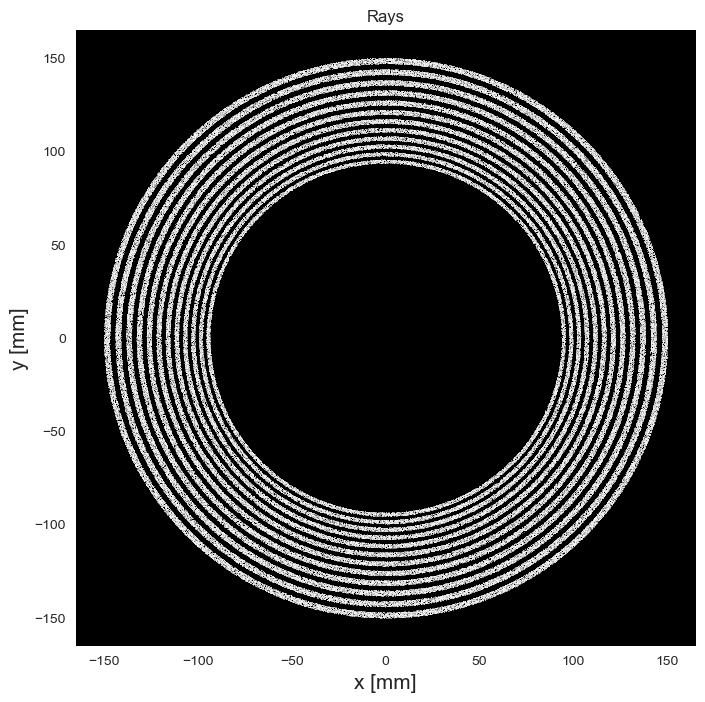

In [34]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[1], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[1], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[1], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[1], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[1], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[1], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[1], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[1], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[1], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[1], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()


In [35]:
print(len(rays[1]))
print(len(som1[0]))


1000000
14221


In [36]:
def loc_primary(rays, r_int):
    # Propagate these photons to primary mirror.
    surfaces.wolterprimary(rays, r_int.to('mm').value, z0.to('mm').value)
    
    # Find which photons interact with this mirror.
    ind = np.where((rays[3] > (z0 + mirror_sep/2).to('mm').value) &
                   (rays[3] < (z0 + mirror_sep/2 + mirror_length).to('mm').value))[0]

    # Keep only the photons which interact with the actual size
    # of the mirror
    ind_rays = [r[ind] for r in rays]
    
    return ind_rays

In [37]:
som1 = loc_primary(som1, r_int[0])
som2 = loc_primary(som2, r_int[1])
som3 = loc_primary(som3, r_int[2])
som4 = loc_primary(som4, r_int[3])
som5 = loc_primary(som5, r_int[4])
som6 = loc_primary(som6, r_int[5])
som7 = loc_primary(som7, r_int[6])
som8 = loc_primary(som8, r_int[7])
som9 = loc_primary(som9, r_int[8])
som10 = loc_primary(som10, r_int[9])
som11 = loc_primary(som11, r_int[10])
som12 = loc_primary(som12, r_int[11])

In [38]:
trans.reflect(som1)
trans.reflect(som2)
trans.reflect(som3)
trans.reflect(som4)
trans.reflect(som5)
trans.reflect(som6)
trans.reflect(som7)
trans.reflect(som8)
trans.reflect(som9)
trans.reflect(som10)
trans.reflect(som11)
trans.reflect(som12)

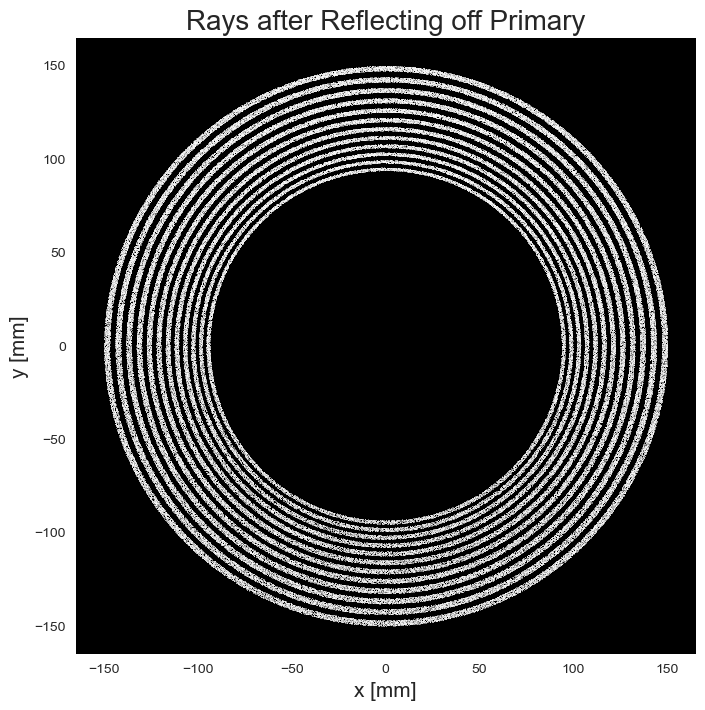

In [39]:
with sns.axes_style("ticks"):
    
   #matplotlib.rc('text',usetex=True)
   # matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[1], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[1], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[1], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[1], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[1], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[1], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[1], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[1], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[1], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[1], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays after Reflecting off Primary", fontsize=20)
    #ax1.grid()

In [40]:
som1

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 10.15665935, -67.18823427, -91.11644034, ..., -81.04510735,
         56.18144746,   0.70657285]),
 array([ 93.41017158, -66.0758597 ,  25.44822993, ..., -49.37193048,
         74.96185686, -95.38252134]),
 array([3555.45056778, 3596.7443026 , 3652.3300266 , ..., 3697.15574864,
        3513.099565  , 3771.03633364]),
 array([-1.75260931e-03,  8.01083146e-03,  1.34864159e-02, ...,
         9.96480454e-03, -9.40609148e-03, -7.58399913e-05]),
 array([-0.01465603,  0.00933535, -0.00231117, ...,  0.00752412,
        -0.01108932,  0.01166059]),
 array([-0.99989106, -0.99992434, -0.99990638, ..., -0.99992204,
        -0.99989427, -0.99993201]),
 array([-0.10809234,  0.71296856,  0.96311944, ...,  0.85399216,
        -0.59971369, -0.00740742]),
 array([-0.99411857,  0.70116459, -0.268993  , ...,  0.52024413,
        -0.80018679,  0.99995106]),
 array([0.00665711, 0.00663772, 0.00661188, ..., 0.00659127, 0.00667718,
        0.0065577 ])]

In [41]:
def beck(num):
    som_list = [som1, som2, som3, som4, som5, som6, som7, som8, som9, som10, som11, som12]
    
    for som in som_list:
        ogre.beckmann_scatter(som, 0, 0, num)

beck(1.96e-4)  # used to be 1.48e-5

In [42]:
def loc_secondary(rays, r_int):
    
    # Propagate photons to the secondary mirror.
    surfaces.woltersecondary(rays, r_int.to('mm').value, z0.to('mm').value)

    # Find which photons will interact with hyperboloid.
    ind = np.where((rays[3] < (z0 - mirror_sep/2).to('mm').value) &
                   (rays[3] > (z0 - mirror_sep/2 - mirror_length).to('mm').value))[0]
    
    # keep only photons which interact with mirror.
    ind_rays = [r[ind] for r in rays]
    
    return ind_rays  

In [43]:
som1 = loc_secondary(som1, r_int[0])
som2 = loc_secondary(som2, r_int[1])
som3 = loc_secondary(som3, r_int[2])
som4 = loc_secondary(som4, r_int[3])
som5 = loc_secondary(som5, r_int[4])
som6 = loc_secondary(som6, r_int[5])
som7 = loc_secondary(som7, r_int[6])
som8 = loc_secondary(som8, r_int[7])
som9 = loc_secondary(som9, r_int[8])
som10 = loc_secondary(som10, r_int[9])
som11 = loc_secondary(som11, r_int[10])
som12 = loc_secondary(som12, r_int[11])

In [44]:
trans.reflect(som1)
trans.reflect(som2)
trans.reflect(som3)
trans.reflect(som4)
trans.reflect(som5)
trans.reflect(som6)
trans.reflect(som7)
trans.reflect(som8)
trans.reflect(som9)
trans.reflect(som10)
trans.reflect(som11)
trans.reflect(som12)

In [45]:
def gauss(num):
    som_list = [som1, som2, som3, som4, som5, som6, som7, som8, som9, som10, som11, som12]

    for som in som_list:
        som[5] += np.random.normal(scale=num, size=len(som[5]))
        som[6] = -np.sqrt(1. - som[5]**2 - som[4]**2)

gauss(1.2e-5)  # originally 1.2e-5

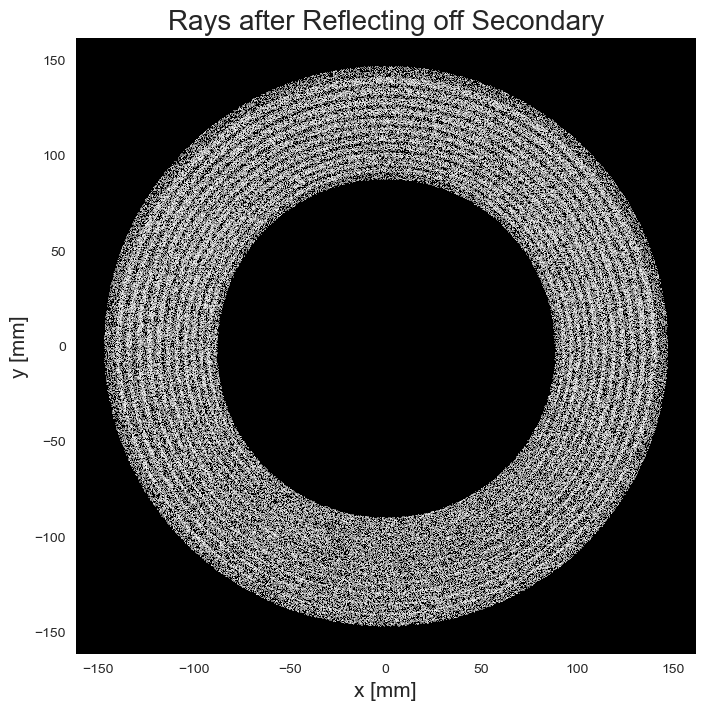

In [46]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[1], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[1], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[1], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[1], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[1], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[1], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[1], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[1], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[1], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[1], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays after Reflecting off Secondary", fontsize=20)
    #ax1.grid()

In [47]:
# List of som arrays to append
som_list = [som1, som2, som3, som4, som5, som6, 
            som7, som8, som9, som10, som11, som12]

# Append all som arrays to new_rays
for som in som_list:
    new_rays = [np.append(new_rays[i], som[i]) for i in range(len(new_rays))]

print(len(new_rays[0]))


253576


In [48]:
rays = trans.copy_rays(new_rays)

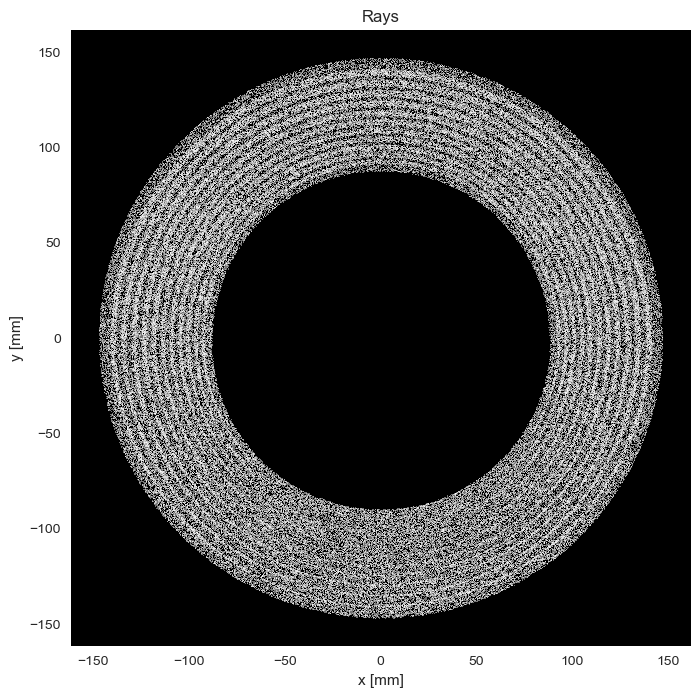

In [49]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

In [50]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([   9.91441158,  -65.93426507,  -86.69925276, ..., -142.21375705,
         120.88922038,  126.5117573 ]),
 array([ 91.38473404, -64.60886485,  24.68613043, ...,  33.72081959,
        -80.50811843,  62.99770631]),
 array([3416.8111311 , 3436.31023012, 3328.53936899, ..., 3475.49673101,
        3446.51429319, 3322.50355084]),
 array([-0.00290737,  0.01938336,  0.02589639, ...,  0.04087258,
        -0.03515812, -0.03800927]),
 array([-0.02531402,  0.02048961, -0.00584644, ..., -0.00823179,
         0.02491035, -0.01739136]),
 array([-0.99967532, -0.99960215, -0.99964754, ..., -0.99913046,
        -0.99907126, -0.99912604]),
 array([-0.10783622,  0.71410519,  0.96157788, ...,  0.97253878,
        -0.83190625, -0.8947096 ]),
 array([-0.99396567,  0.69975036, -0.27379287, ..., -0.2306022 ,
         0.55402133, -0.44552897]),
 array([0.02008984, 0.02008009, 0.02013562, ..., 0.03147948, 0.03150172,
        0.03160182])]

In [51]:
# Go to the X-ray focus.
#f0 = surfaces.focusX(rays) #put z to focus 
#print(f0)

#might need to flat to make sure we are where we think we are

In [52]:
trans.transform(rays, 0, 0, 0, 0, 0, 0)
surfaces.flat(rays)

In [53]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.02273475,  0.69949462, -0.47172523, ..., -0.03760731,
        -0.39637985,  0.11535679]),
 array([4.86342309, 5.82782019, 5.2191727 , ..., 5.08637656, 5.42556593,
        5.16430866]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00290737,  0.01938336,  0.02589639, ...,  0.04087258,
        -0.03515812, -0.03800927]),
 array([-0.02531402,  0.02048961, -0.00584644, ..., -0.00823179,
         0.02491035, -0.01739136]),
 array([-0.99967532, -0.99960215, -0.99964754, ..., -0.99913046,
        -0.99907126, -0.99912604]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [54]:
# Put optic focus at y=0.


#find mean of y -- finite source so the path length for the rays are different from one another, 
#will be shifted downwards by some amount. 


# each source has different focal length ; each has different magnification 

# ratios between size of image and sie of extra focual image with distance object/ distance sourse is same,
# sanity check; picture 05/27

cen_y = np.mean(rays[2])
print(cen_y)
#trans.transform(rays, 0, cen_y, 0, 0, 0, 0)

# Copy rays to reference later.
of_rays = deepcopy(rays)

rays

5.090503714963096


[array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.02273475,  0.69949462, -0.47172523, ..., -0.03760731,
        -0.39637985,  0.11535679]),
 array([4.86342309, 5.82782019, 5.2191727 , ..., 5.08637656, 5.42556593,
        5.16430866]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00290737,  0.01938336,  0.02589639, ...,  0.04087258,
        -0.03515812, -0.03800927]),
 array([-0.02531402,  0.02048961, -0.00584644, ..., -0.00823179,
         0.02491035, -0.01739136]),
 array([-0.99967532, -0.99960215, -0.99964754, ..., -0.99913046,
        -0.99907126, -0.99912604]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

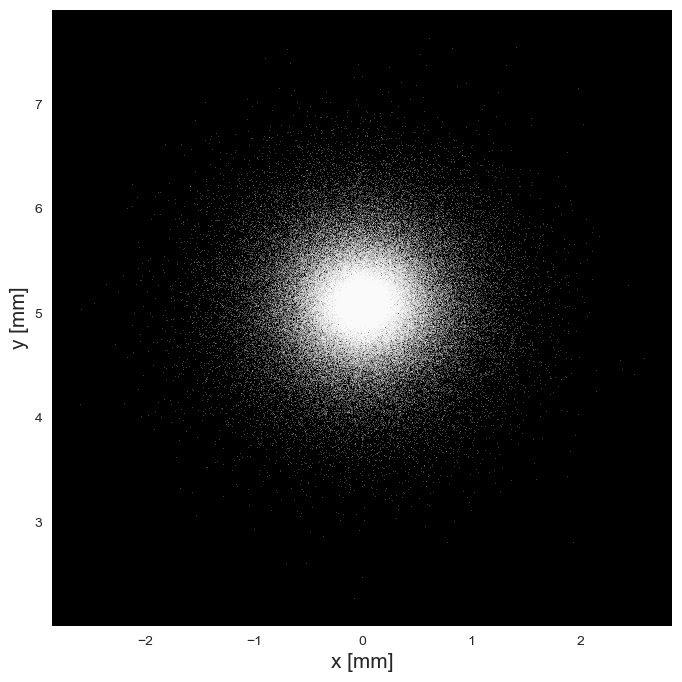

In [55]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.3, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    #ax1.set_title("Rays at Optic Focus [Z=" + str(round(f0, 2)) + " mm]", fontsize=20)
    #ax1.grid()
    
#fwhm_disp = np.std(rays[1]) * 2.355 / (z0.value - f0) * 206265 * u.arcsec
#hpd_xdisp = analyses.hpdY(rays) / (z0.value - f0) * 206265 * u.arcsec
#plt.text(0.15, 0.2, 'Disp. FWHM = ' + str(round(fwhm_disp.value, 2)) + '"')
#plt.text(0.15, 0.15, 'X-Disp. HPD = ' + str(round(hpd_xdisp.value, 2)) + '"')

#print('Optic FWHM (Disp. Dir.): ' + str(fwhm_disp))
#print('Optic HPD (X-Disp. Dir.): ' + str(hpd_xdisp))


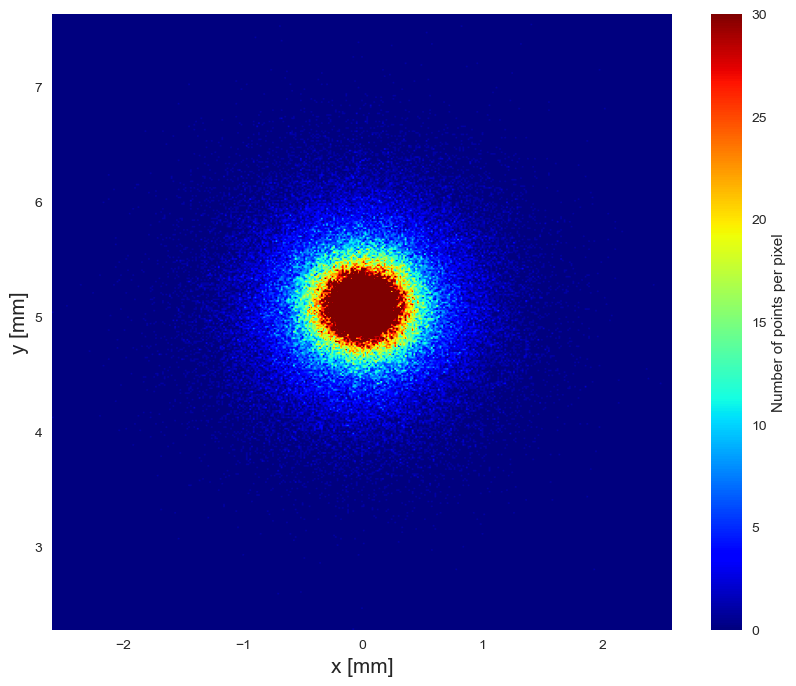

In [56]:
sns.set_style("ticks")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1, 1, 1, projection='scatter_density')

#color_map = plt.get_cmap('plasma')
color_map = plt.get_cmap('jet')

density = ax1.scatter_density(rays[1], rays[2], cmap = color_map, vmin=0, vmax=30)
#ax1.set_ylim(-180,180)
#ax1.set_xlim(-180,180)

ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)

#ax1.set_title("Rays", fontsize=20)

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)

fig.colorbar(density, label='Number of points per pixel')

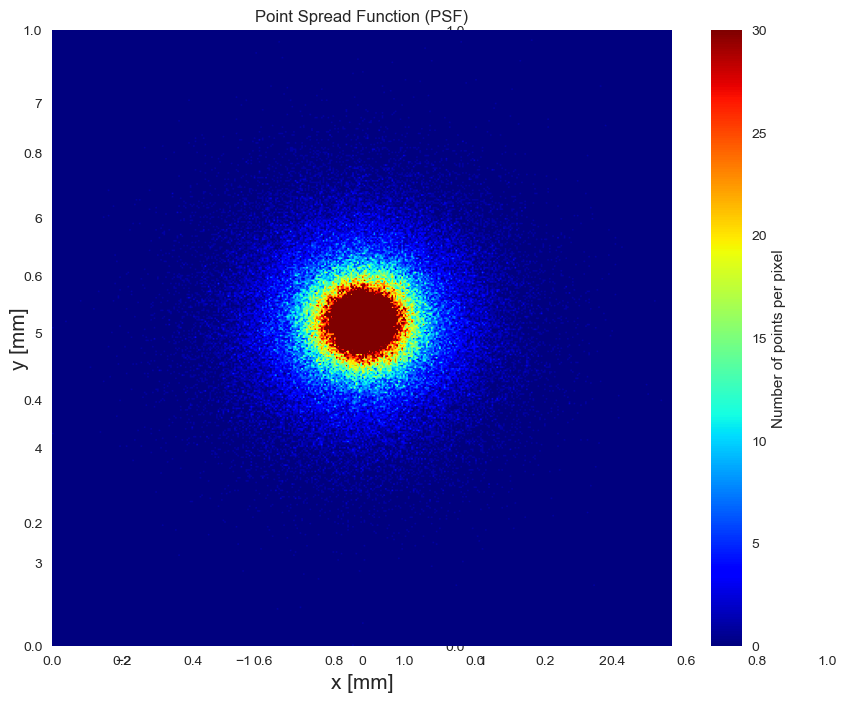

In [57]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 8)) 

ax1 = fig.add_subplot(1, 1, 1, projection='scatter_density')
ax1.set_title("Point Spread Function (PSF)")
color_map = plt.get_cmap('jet')

density = ax1.scatter_density(rays[1], rays[2], cmap = color_map, vmin=0, vmax=30)
ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)
fig.colorbar(density, ax=ax1, label='Number of points per pixel')

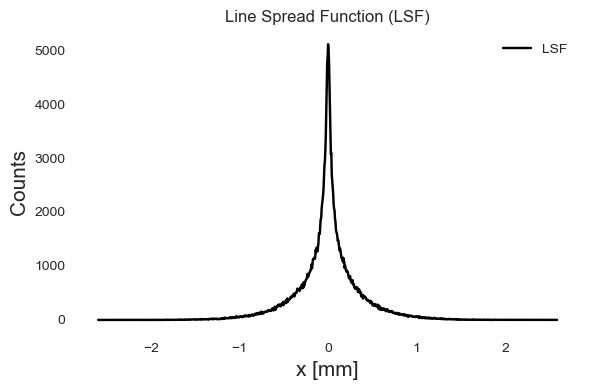

In [58]:
fig, ax2 = plt.subplots(figsize=(6, 4))

ax2.set_title("Line Spread Function (LSF)")

# Bin data along x-axis
bins = np.linspace(min(rays[1]), max(rays[1]), 1000)  # Define bins for LSF
lsf, bin_edges = np.histogram(rays[1], bins=bins)

# Plot LSF
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Get bin centers
ax2.plot(bin_centers, lsf, '-', color='black', label='LSF')
ax2.set_xlabel("x [mm]", fontsize=15)
ax2.set_ylabel("Counts", fontsize=15)
ax2.legend()

plt.tight_layout()
plt.show()

## Analysis

In [59]:
#gauss both sides to get it maybe

bins = 1000  # Adjust for resolution
hist, xedges, yedges = np.histogram2d(rays[1], rays[2], bins=bins)

column_sums = (np.sum(hist, axis=0))
xdat_col = np.arange(1, len(column_sums) + 1, 1)

row_sums = (np.sum(hist, axis=1))
xdat_row = np.arange(1, len(row_sums) + 1, 1)

In [60]:
lsf_x = np.sum(hist.T, axis=0)  # Collapse along y-axis to get LSF in x
lsf_y = np.sum(hist.T, axis=1)  # Collapse along x-axis to get LSF in y

x_bin_centers = (xedges[:-1] + xedges[1:]) / 2
y_bin_centers = (yedges[:-1] + yedges[1:]) / 2

In [61]:
print(xedges)

[-2.59546613 -2.59028591 -2.58510568 ...  2.574396    2.57957623
  2.58475645]


In [62]:
hist.T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

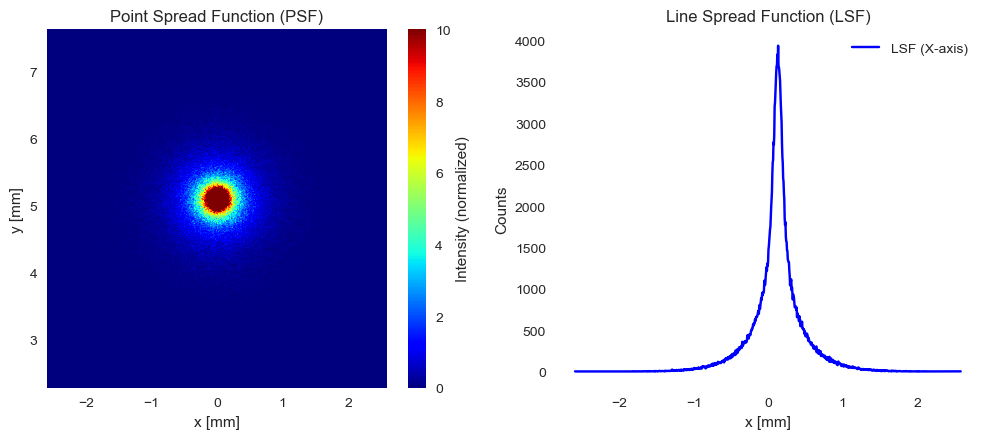

In [63]:
plt.figure(figsize=(10, 4.5))
plt.subplot(1, 2, 1)
plt.imshow(hist.T, cmap = color_map, origin='lower', 
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', vmin=0, vmax=10)

plt.colorbar(label="Intensity (normalized)")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title("Point Spread Function (PSF)")


# Plot LSF
plt.subplot(1, 2, 2)
plt.plot(x_bin_centers, lsf_y, label="LSF (X-axis)", color='blue')
#plt.plot(xdat_row, row_sums, label="LSF (X-axis)", color='blue')
plt.xlabel("x [mm]")
plt.ylabel("Counts")
plt.title("Line Spread Function (LSF)")
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
top = np.where(lsf_y == np.max(lsf_y))
print(x_bin_centers[top])
print(np.max(lsf_y))

[0.13192106]
3938.0


In [65]:
from scipy.ndimage import center_of_mass

psf_centroid = center_of_mass(hist.T)

print(psf_centroid)

(524.8165126037164, 500.677075117519)


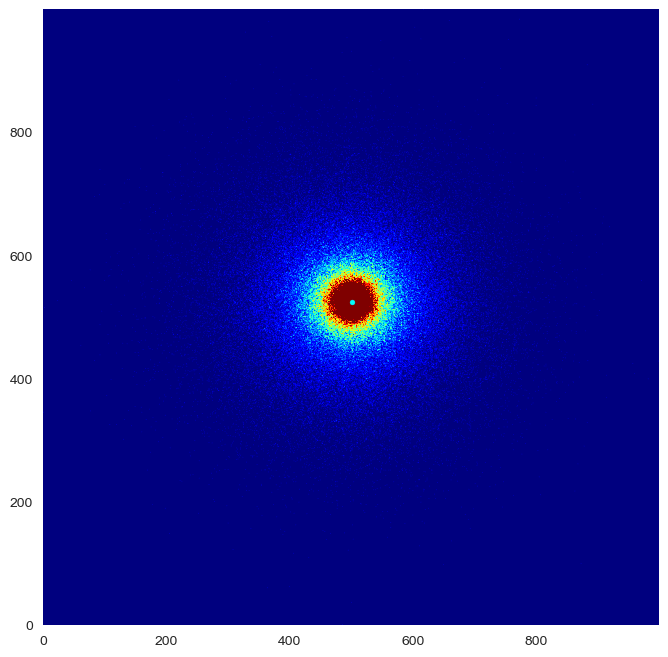

In [66]:
plt.figure(figsize=(8,8))
plt.imshow(hist.T, cmap = color_map, origin='lower', vmin=0, vmax=10)
plt.scatter(psf_centroid[1], psf_centroid[0], color="cyan", marker = '.')

In [67]:
# Sample point spread function data (replace this with your actual data)
psf_data = hist.T

h = psf_centroid[0]
k = psf_centroid[1]

def circle(x,y):
    R = (x-h)**2 + (y-k)**2
    return R

vals = np.linspace(0,500,10000)

rad_vals = circle(h+vals,k+vals)

rad_vals

array([0.00000000e+00, 5.00100015e-03, 2.00040006e-02, ...,
       4.99800000e+05, 4.99899995e+05, 5.00000000e+05])

In [68]:
sum_sum = np.sum(hist.T)
sum_sum 

253576.0

In [69]:
import cv2

target_sum = sum_sum/2  # Adjust the target sum based on your requirements
center_coordinates = (int(psf_centroid[0]), int(psf_centroid[1]))
current_radius = 1

In [70]:
# Iterate to find the circle with the desired sum
while True:
    # Extract region within the circle
    mask = np.zeros_like(hist.T)
    y, x = np.ogrid[:mask.shape[0], :mask.shape[1]]
    mask_circle = (x - center_coordinates[1])**2 + (y - center_coordinates[0])**2 <= current_radius**2
    region_of_interest = np.multiply(hist.T, mask_circle)

    # Sum pixel values within the circle
    sum_of_pixels = np.sum(region_of_interest)

    print(f"Radius: {current_radius}, Sum of pixel values within the circle: {sum_of_pixels}")

    # Check if the target sum is reached
    if sum_of_pixels >= target_sum:
        break

    # Increase the radius for the next iteration
    #current_radius += 0.001
    
    current_radius += 0.1

Radius: 1, Sum of pixel values within the circle: 776.0
Radius: 1.1, Sum of pixel values within the circle: 776.0
Radius: 1.2000000000000002, Sum of pixel values within the circle: 776.0
Radius: 1.3000000000000003, Sum of pixel values within the circle: 776.0
Radius: 1.4000000000000004, Sum of pixel values within the circle: 776.0
Radius: 1.5000000000000004, Sum of pixel values within the circle: 1446.0
Radius: 1.6000000000000005, Sum of pixel values within the circle: 1446.0
Radius: 1.7000000000000006, Sum of pixel values within the circle: 1446.0
Radius: 1.8000000000000007, Sum of pixel values within the circle: 1446.0
Radius: 1.9000000000000008, Sum of pixel values within the circle: 1446.0
Radius: 2.000000000000001, Sum of pixel values within the circle: 2080.0
Radius: 2.100000000000001, Sum of pixel values within the circle: 2080.0
Radius: 2.200000000000001, Sum of pixel values within the circle: 2080.0
Radius: 2.300000000000001, Sum of pixel values within the circle: 3292.0
Radiu

Radius: 15.299999999999963, Sum of pixel values within the circle: 51647.0
Radius: 15.399999999999963, Sum of pixel values within the circle: 51647.0
Radius: 15.499999999999963, Sum of pixel values within the circle: 51647.0
Radius: 15.599999999999962, Sum of pixel values within the circle: 52058.0
Radius: 15.699999999999962, Sum of pixel values within the circle: 52639.0
Radius: 15.799999999999962, Sum of pixel values within the circle: 52639.0
Radius: 15.899999999999961, Sum of pixel values within the circle: 53189.0
Radius: 15.999999999999961, Sum of pixel values within the circle: 53189.0
Radius: 16.099999999999962, Sum of pixel values within the circle: 53638.0
Radius: 16.199999999999964, Sum of pixel values within the circle: 54457.0
Radius: 16.299999999999965, Sum of pixel values within the circle: 54980.0
Radius: 16.399999999999967, Sum of pixel values within the circle: 54980.0
Radius: 16.499999999999968, Sum of pixel values within the circle: 55463.0
Radius: 16.59999999999997

Radius: 30.60000000000017, Sum of pixel values within the circle: 93729.0
Radius: 30.70000000000017, Sum of pixel values within the circle: 93930.0
Radius: 30.80000000000017, Sum of pixel values within the circle: 93930.0
Radius: 30.900000000000173, Sum of pixel values within the circle: 94296.0
Radius: 31.000000000000174, Sum of pixel values within the circle: 94347.0
Radius: 31.100000000000176, Sum of pixel values within the circle: 94863.0
Radius: 31.200000000000177, Sum of pixel values within the circle: 95103.0
Radius: 31.30000000000018, Sum of pixel values within the circle: 95285.0
Radius: 31.40000000000018, Sum of pixel values within the circle: 95627.0
Radius: 31.50000000000018, Sum of pixel values within the circle: 95820.0
Radius: 31.600000000000183, Sum of pixel values within the circle: 95913.0
Radius: 31.700000000000184, Sum of pixel values within the circle: 96088.0
Radius: 31.800000000000185, Sum of pixel values within the circle: 96340.0
Radius: 31.900000000000187, Sum

Radius: 45.10000000000037, Sum of pixel values within the circle: 122776.0
Radius: 45.20000000000037, Sum of pixel values within the circle: 122967.0
Radius: 45.300000000000374, Sum of pixel values within the circle: 123230.0
Radius: 45.400000000000375, Sum of pixel values within the circle: 123414.0
Radius: 45.50000000000038, Sum of pixel values within the circle: 123529.0
Radius: 45.60000000000038, Sum of pixel values within the circle: 123631.0
Radius: 45.70000000000038, Sum of pixel values within the circle: 123897.0
Radius: 45.80000000000038, Sum of pixel values within the circle: 123984.0
Radius: 45.90000000000038, Sum of pixel values within the circle: 124196.0
Radius: 46.000000000000384, Sum of pixel values within the circle: 124268.0
Radius: 46.100000000000385, Sum of pixel values within the circle: 124726.0
Radius: 46.20000000000039, Sum of pixel values within the circle: 124887.0
Radius: 46.30000000000039, Sum of pixel values within the circle: 125041.0
Radius: 46.4000000000

In [71]:
print(current_radius)

#rad_rad = current_radius - 1

rad_rad = current_radius #pixels

47.400000000000404


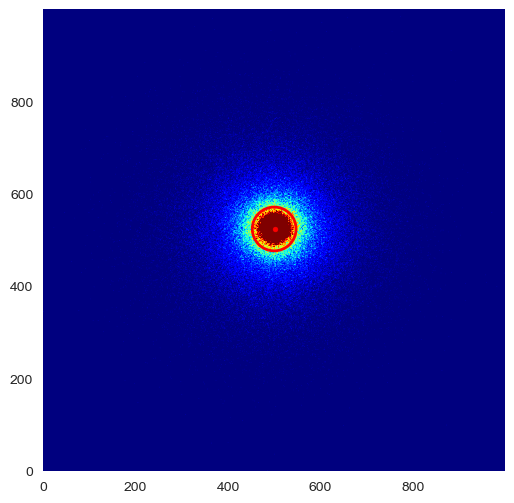

In [72]:
fig, ax1 = plt.subplots(figsize=(6,6))
plt.imshow(hist.T, cmap = color_map, origin='lower', vmin=0, vmax=10)
ax1.scatter(psf_centroid[1], psf_centroid[0], color="red", marker = '.')

circle = Circle((int(psf_centroid[1]), int(psf_centroid[0])), rad_rad, edgecolor='red', 
                facecolor='none', linewidth=2)
ax1.add_patch(circle)


plt.show()

In [73]:
np.max(rays[1])

2.5847564476053364

In [74]:
np.min(rays[1])

-2.5954661292296652

In [75]:
how_mm = np.max(rays[1]) + np.abs(np.min(rays[1]))
how_mm

5.180222576835002

In [76]:
convert = how_mm/bins
convert

0.005180222576835002

In [77]:
mm_extent = rad_rad*convert
mm_extent

0.24554255014198118

In [78]:
def radians_to_arcseconds(radians):
    
    return radians * 206264.80624709636

In [79]:
HEW = radians_to_arcseconds(math.tan(mm_extent/3500)) 
print(HEW)

14.470510461012447


In [80]:
psf_centroid_mm = analyses.centroid(rays)

print(psf_centroid_mm)

(0.0007430546398790076, 5.090503714963096)


In [81]:
mm_extent

0.24554255014198118

In [82]:
rad_rad

47.400000000000404

In [83]:
circle_center = (psf_centroid_mm[0], psf_centroid_mm[1])
circle_radius = mm_extent

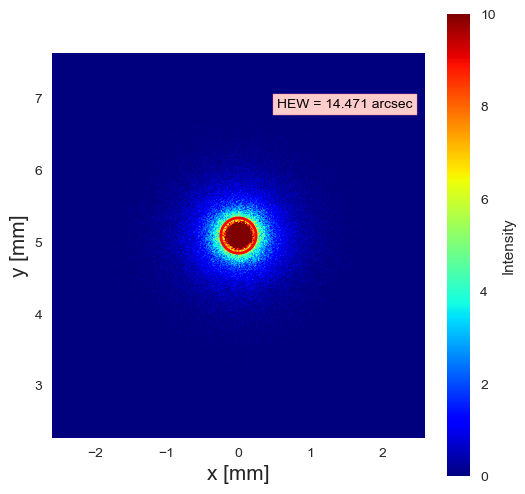

In [84]:
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(hist.T, cmap=color_map, origin='lower', 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', vmin=0, vmax=10)

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Intensity")  # Set a label for the colorbar

# Draw a circle
circle = plt.Circle(circle_center, circle_radius, color='red', fill=False, linewidth=2)
ax.add_patch(circle)

# Remove axes for a cleaner look
# ax.set_xticks([])
# ax.set_yticks([])

# ax.set_title("50 Micron Fiber Optic", fontsize=20)

ax.set_xlabel('x [mm]', fontsize=15)
ax.set_ylabel('y [mm]', fontsize=15)

ax.text(0.605, 0.85, "HEW = " + str(round(HEW, 3)) + " arcsec", 
         horizontalalignment='left', verticalalignment='bottom', 
         transform=ax.transAxes, fontsize=10, color="black", 
         bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))

ax.set_aspect('equal')

plt.show()


In [85]:
HEW/mm_extent

58.93280188156838

In [86]:
print(len(rays[1]))

253576


In [87]:
def line1(x,a1,mu,sig,c):
    y1 = 1 + a1*e**((-(x-mu)**2)/(2*sig**2))+c
    return y1

In [88]:
gg_1 = np.mean(x_bin_centers)
sd_1 = np.std(x_bin_centers)

#p1= np.array([100,gg_1,sd_1,0])
p1= np.array([1,gg_1,sd_1,0])
coeff1, covar_matrix1 = curve_fit(line1, x_bin_centers, lsf_y,p0=p1)
xarr1=np.linspace(np.min(x_bin_centers),np.max(x_bin_centers),1000)
yarr1=line1(xarr1,*coeff1)

In [89]:
mod_lorentz = (LorentzianModel(prefix='v2_'))

print(f'parameter names: {mod_lorentz.param_names}')

parameter names: ['v2_amplitude', 'v2_center', 'v2_sigma']


In [90]:
pars_lorentz = mod_lorentz.make_params(v2_amplitude=1000, v2_center=0, v2_sigma=10)

In [91]:
# fit this model to data array y
result_lorentz = mod_lorentz.fit(lsf_y, params=pars_lorentz, x=x_bin_centers)

print(result_lorentz.fit_report())

# generate components
comps_lorentz = result_lorentz.eval_components(x=x_bin_centers)

[[Model]]
    Model(lorentzian, prefix='v2_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 1000
    # variables        = 3
    chi-square         = 4815889.43
    reduced chi-square = 4830.38057
    Akaike info crit   = 8485.67603
    Bayesian info crit = 8500.39929
    R-squared          = 0.98748453
[[Variables]]
    v2_amplitude:  1290.46545 +/- 6.01843694 (0.47%) (init = 1000)
    v2_center:     0.12819011 +/- 5.3699e-04 (0.42%) (init = 0)
    v2_sigma:      0.11515726 +/- 7.5954e-04 (0.66%) (init = 10)
    v2_fwhm:       0.23031452 +/- 0.00151907 (0.66%) == '2.0000000*v2_sigma'
    v2_height:     3567.01717 +/- 16.6338083 (0.47%) == '0.3183099*v2_amplitude/max(1e-15, v2_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(v2_amplitude, v2_sigma) = +0.7072


In [92]:
fwhm_lorentz = result_lorentz.params["v2_fwhm"].value

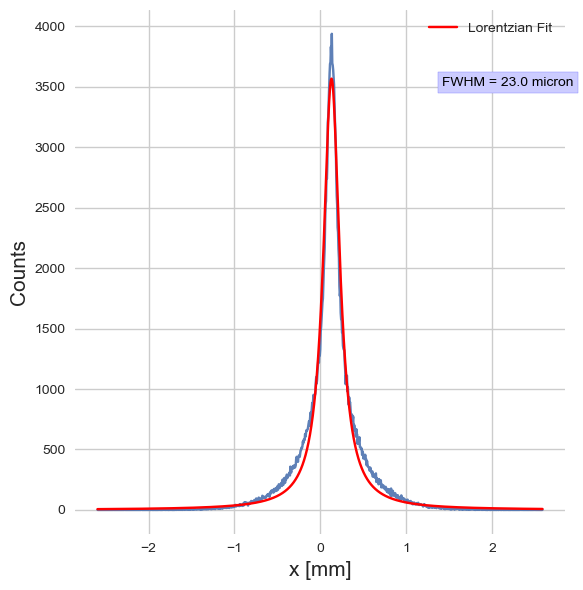

In [93]:
# Second subplot: LSF Voigt profile fit
fig, ax2 = plt.subplots(figsize=(6, 6))
x_new_lorentz = np.linspace(min(x_bin_centers), max(x_bin_centers), 1000000)  # Adjust as needed
result_new_lorentz = result_lorentz.eval(x=x_new_lorentz)

ax2.plot(x_bin_centers, lsf_y, '-', alpha=0.9)
ax2.plot(x_new_lorentz, result_new_lorentz, '-', label="Lorentzian Fit", color="red")
ax2.legend()

# Labels
ax2.set_xlabel('x [mm]', fontsize=15)
ax2.set_ylabel('Counts', fontsize=15)
#ax2.set_title("Line Spread Function (LSF) Fit")

# Add text to the second subplot
ax2.text(0.75, 0.85, f"FWHM = {round(fwhm_lorentz*100, 1)} micron", 
         horizontalalignment='left', verticalalignment='bottom', 
         transform=ax2.transAxes, fontsize=10, color="black", 
         bbox=dict(boxstyle="square", ec=(0.5, 0.5, 1.), fc=(0.8, 0.8, 1.)))

ax2.grid()

# Adjust layout
plt.tight_layout()
plt.show()

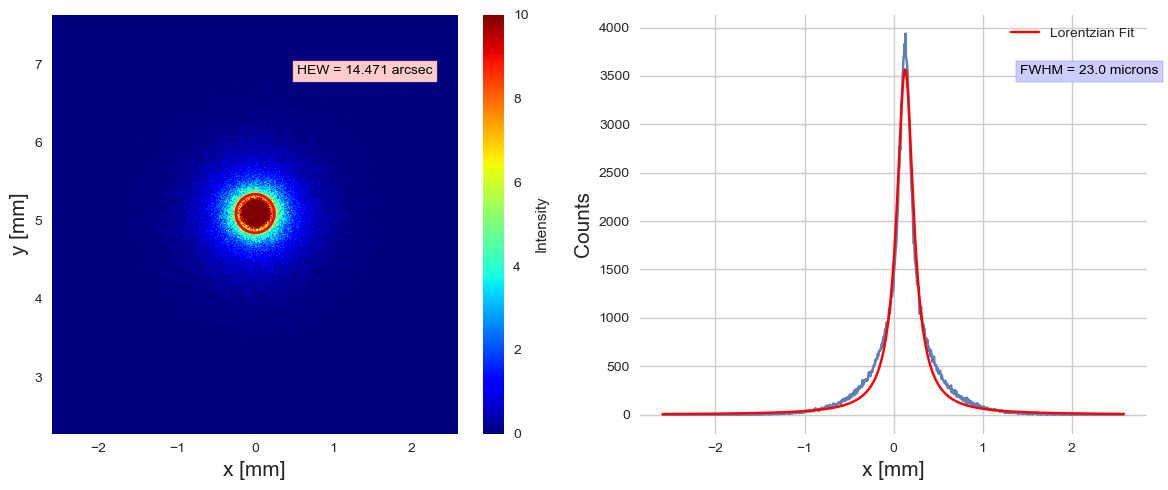

In [94]:
# Create a figure with two subplots next to each other
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# First subplot: Image with colorbar
ax1 = axes[0]
im = ax1.imshow(hist.T, cmap=color_map, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                aspect='auto', vmin=0, vmax=10)

# Add colorbar
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# Draw a circle
circle = plt.Circle(circle_center, circle_radius, color='red', fill=False, linewidth=2)
ax1.add_patch(circle)

# Labels
ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)
ax1.text(0.605, 0.85, f"HEW = {round(HEW,3)} arcsec", 
         horizontalalignment='left', verticalalignment='bottom', 
         transform=ax1.transAxes, fontsize=10, color="black", 
         bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))

ax1.set_aspect('equal')

# Second subplot: LSF Voigt profile fit
ax2 = axes[1]
x_new_lorentz = np.linspace(min(x_bin_centers), max(x_bin_centers), 1000000)  # Adjust as needed
result_new_lorentz = result_lorentz.eval(x=x_new_lorentz)

ax2.plot(x_bin_centers, lsf_y, '-', alpha=0.9)
ax2.plot(x_new_lorentz, result_new_lorentz, '-', label="Lorentzian Fit", color="red")
ax2.legend()

# Labels
ax2.set_xlabel('x [mm]', fontsize=15)
ax2.set_ylabel('Counts', fontsize=15)
#ax2.set_title("Line Spread Function (LSF) Fit")

# Add text to the second subplot
ax2.text(0.75, 0.85, f"FWHM = {round(fwhm_lorentz*100, 1)} microns", 
         horizontalalignment='left', verticalalignment='bottom', 
         transform=ax2.transAxes, fontsize=10, color="black", 
         bbox=dict(boxstyle="square", ec=(0.5, 0.5, 1.), fc=(0.8, 0.8, 1.)))

ax2.grid()

# Adjust layout
plt.tight_layout()
plt.show()